# Analysis of Processed MIMIC-III Discharge Notes with Assigned Top-Level ICD-9 Codes (after R Script)
**ATTENTION: Make sure to first run the `01_create_admission_note_table.R` script to generate the required files for this notebook.**

*The R script receives 2 files from the MIMIC-III database as input (`NOTEEVENTS.csv` and `DIAGNOSES_ICD.csv`), filters discharge notes, extracts the associated ICD-9 codes, maps these codes to top-level categories, and splits the data into training and testing sets.*

---

This notebook explores the characteristics of the **MIMIC-III discharge notes with ICD-9 Top-Level Categories dataset** *after* initial processing (located at `intermediate_files/icd9NotesDataTable[_train,_test].csv`).

We will examine:
1.  Dataset size and train/test split distribution.
2.  Distribution of records per top-level category and the number of records without any assigned categories.
3.  Statistics on the number of assigned top-level categories per record (min, max, average, mean).
4.  Statistics on the length of the clinical notes (min, max, average, mean).
5.  Category distribution comparison between train/test sets.

## 1. Setup and Data Loading
Import necessary libraries and load the training and testing datasets generated by the `01_create_admission_note_table.R` script.

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import os
import re 

# Set plot style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6) # Default figure size

In [92]:
category_mapping = {
    "cat:1": "1: Infectious & Parasitic (ICD-9 001-139)",
    "cat:2": "2: Neoplasms (ICD-9 140-239)",
    "cat:3": "3: Endocrine, Nutritional and Metabolic (ICD-9 240-279)",
    "cat:4": "4: Blood & Blood-forming Organs (ICD-9 280-289)",
    "cat:5": "5: Mental Disorders (ICD-9 290-319)",
    "cat:6": "6: Nervous System (ICD-9 320-359)",
    "cat:7": "7: Sense Organs (ICD-9 360-389)",
    "cat:8": "8: Circulatory System (ICD-9 390-459)",
    "cat:9": "9: Respiratory System (ICD-9 460-519)",
    "cat:10": "10: Digestive System (ICD-9 520-579)",
    "cat:11": "11: Genitourinary System (ICD-9 580-629)",
    "cat:12": "12: Pregnancy & Childbirth complications (ICD-9 630-679)",
    "cat:13": "13: Skin & Subcutaneous Tissue (ICD-9 680-709)",
    "cat:14": "14: Musculoskeletal System & Connective Tissue (ICD-9 710-739)",
    "cat:15": "15: Congenital Anomalies (ICD-9 740-759)",
    "cat:16": "16: Perinatal Period Conditions (ICD-9 760-779)",
    "cat:17": "17: Injury and Poisoning (ICD-9 800-999)",
    "cat:18": "18: External Causes of Injury (ICD-9 E800-E999)",
    "cat:19": "19: Supplementary (ICD-9 V01-V82)"
    # N/A or records without categories are handled separately
}

# Helper function to get numerical sort key from category ID
def get_cat_sort_key(cat_id):
    """Extracts the integer number from 'cat:X' for sorting."""
    if pd.isna(cat_id) or not isinstance(cat_id, str):
        return 99 # Place unknowns last
    match = re.search(r'cat:(\d+)', cat_id)
    return int(match.group(1)) if match else 99

In [97]:
# Define file paths
data_folder = 'intermediate_files'
train_file = os.path.join(data_folder, 'icd9NotesDataTable_traincsv')
test_file = os.path.join(data_folder, 'icd9NotesDataTable_test.csv')

# Check if files exist
if not os.path.exists(train_file) or not os.path.exists(test_file):
    raise FileNotFoundError(
        f"Ensure '{train_file}' and '{test_file}' exist in the '{data_folder}' directory."
        " Please run the 01_create_admission_note_table.R script first."
    )

# Load the datasets
# The R write.csv function adds an unnamed index column, so we set index_col=0
try:
    df_train = pd.read_csv(train_file, index_col=0)
    df_test = pd.read_csv(test_file, index_col=0)
    print(f"Loaded training data: {df_train.shape[0]} records, {df_train.shape[1]} columns")
    print(f"Loaded testing data : {df_test.shape[0]} records, {df_test.shape[1]} columns")

    # Combine for some overall analyses
    df_full = pd.concat([df_train, df_test], ignore_index=True)
    print(f"Combined dataset  : {df_full.shape[0]} records")

except Exception as e:
    print(f"Error loading CSV files: {e}")
    print("Please ensure the CSV files were generated correctly by the R script and paths are correct.")
    # Stop execution if files can't be loaded
    raise

Loaded training data: 39541 records, 8 columns
Loaded testing data : 13181 records, 8 columns
Combined dataset  : 52722 records


In [130]:
# Display first few rows and info to understand structure
print("\nTraining Data Head:")
print("-" * 80) 
print(df_train.head())

print("\nTraining Data Info:")
print("-" * 80) 
df_train.info()


Training Data Head:
--------------------------------------------------------------------------------
   HADM_ID  SUBJECT_ID                                          ICD9_CODE  \
1   164658       12132  9974-56722-2851-99859-6822-53200-99662-5185-53...   
2   116554       29432               4241-41401-4019-2724-2449-2749-42731   
3   131679       75627  41401-4139-4240-4019-2724-71590-27800-V4364-V4589   
4   114441       70313            3484-05410-99791-E8798-49390-32723-3051   
5   169704       26137  30751-261-2761-27652-2763-5849-5990-4580-3003-...   

    CHARTDATE DESCRIPTION                                               TEXT  \
1  2141-04-10      Report  Admission Date:  [**2141-3-20**]              ...   
2  2157-08-01      Report  Admission Date:  [**2157-7-26**]              ...   
3  2160-07-04      Report  Admission Date:  [**2160-6-30**]              ...   
4  2130-04-02      Report  Admission Date:  [**2130-3-30**]              ...   
5  2120-07-12      Report  Admissio

## 2. Dataset Size and Train/Test Split
Analyze the total number of records and how they are distributed between the training and testing sets.

According to **Table 2** of the KeyClass paper, the split should be 75/25 (39.541 training records and 13.181 test records).

--------------------------------------------------------------------------------
Total records: 52722
Training records: 39541 (75.00%)
Testing records: 13181 (25.00%)
--------------------------------------------------------------------------------


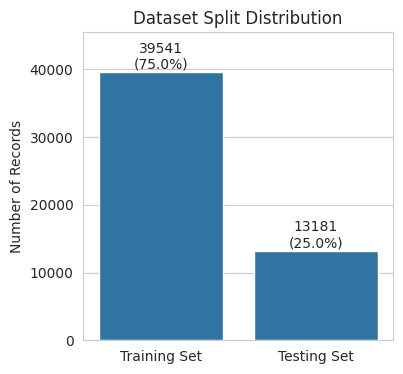

In [129]:
n_train = len(df_train)
n_test = len(df_test)
n_total = n_train + n_test

train_perc = (n_train / n_total) * 100
test_perc = (n_test / n_total) * 100
print("-" * 80) 
print(f"Total records: {n_total}")
print(f"Training records: {n_train} ({train_perc:.2f}%)")
print(f"Testing records: {n_test} ({test_perc:.2f}%)")
print("-" * 80) 
# Visualize the split
plt.figure(figsize=(4, 4))
sns.barplot(x=['Training Set', 'Testing Set'], y=[n_train, n_test])
plt.title('Dataset Split Distribution')
plt.ylabel('Number of Records')
for index, value in enumerate([n_train, n_test]):
    plt.text(index, value + (0.01 * n_total) , f'{value}\n({[train_perc, test_perc][index]:.1f}%)', ha='center')
plt.ylim(0, max(n_train, n_test) * 1.15) # Adjust y-limit for text visibility
plt.show()

## 3. Top-Level ICD-9 Category Assignment Analysis
In this section, we analyze the `TopLevelICD` column generated by the R script. 

This column contains hyphen-separated unique top-level ICD categories derived from the `ICD9_CODE` list for each admission.

In [103]:
def get_categories(cat_string):
    """Splits the hyphen-separated category string and returns a list of unique category IDs."""
    if pd.isna(cat_string) or cat_string == "":
        return []
    # Split and filter out potential empty strings if format is like "cat:1-"
    categories = [cat for cat in cat_string.split('-') if cat and cat.startswith('cat:')] # Ensure format
    return categories

# Apply function to get lists of category IDs for each record
df_full['CategoryList'] = df_full['TopLevelICD'].apply(get_categories)

## 3.1 Records without assigned Top-Level ICD-9 Categories

The R script establishes which top-level categories should be considered for the resulting dataset. Hence, it is ok to have records without any of the desired top-level ICD-9 categories.

In [126]:
# Count records without any assigned top-level categories
records_without_categories = df_full['CategoryList'].apply(len) == 0
n_without_categories = records_without_categories.sum()
perc_without_categories = (n_without_categories / n_total) * 100

print("-" * 80) 
print(f"Number of records with NO assigned top-level categories: {n_without_categories} ({perc_without_categories:.2f}%)")
print("-" * 80) 
print("(Based on empty or unmappable 'TopLevelICD' column after R script processing)")

--------------------------------------------------------------------------------
Number of records with NO assigned top-level categories: 8 (0.02%)
--------------------------------------------------------------------------------
(Based on empty or unmappable 'TopLevelICD' column after R script processing)


## 3.2 Records Per Assigned Top-Evel ICD-9 Category

**Observation**: it must be noted that the same discharge note can have multiple top-level ICD-9 categories assigned to it. 

In [105]:
# Count occurrences of each individual category ID (multi-label counting)
all_category_ids = Counter()
# Iterate through the lists of categories for records that *have* categories
for cat_list in df_full.loc[~records_without_categories, 'CategoryList']:
    all_category_ids.update(cat_list)

# Prepare data for plotting, map IDs to names, and sort numerically
category_counts_df = pd.DataFrame(all_category_ids.items(), columns=['CategoryID', 'Count'])
category_counts_df['CategoryName'] = category_counts_df['CategoryID'].map(category_mapping).fillna('Unknown Category') # Map IDs to names
category_counts_df['SortKey'] = category_counts_df['CategoryID'].apply(get_cat_sort_key)
category_counts_df = category_counts_df.sort_values('SortKey').reset_index(drop=True)

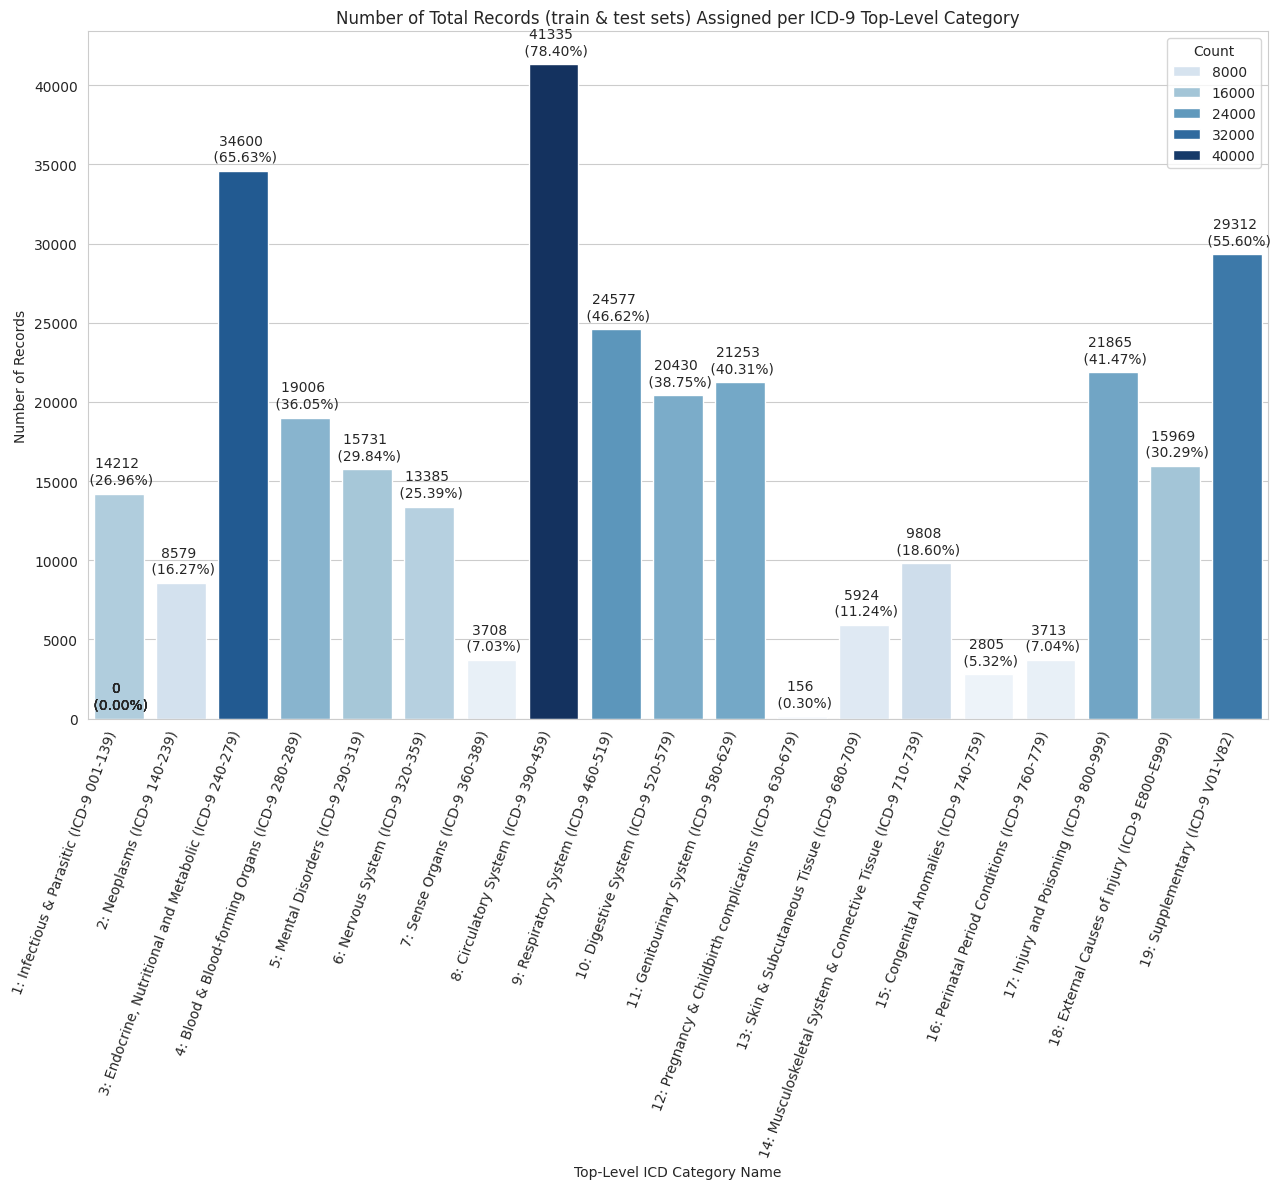

In [118]:
plt.figure(figsize=(13, 12))
ax = sns.barplot(
    x='CategoryName',
    y='Count',
    data=category_counts_df,
    order=category_counts_df['CategoryName'],
    palette='Blues',
    hue='Count',
    dodge=False
)

for p in ax.patches:
    count = p.get_height()
    pct = count / n_total * 100
    ax.annotate(
        f'{int(count)} \n ({pct:.2f}%)',
        (p.get_x() + p.get_width() / 2, count),
        ha='center',
        va='bottom',
        xytext=(0, 5),
        textcoords='offset points'
    )

ax.set_title('Number of Total Records (train & test sets) Assigned per ICD-9 Top-Level Category')
ax.set_xlabel('Top-Level ICD Category Name')
ax.set_ylabel('Number of Records')
plt.xticks(rotation=70, ha='right')
plt.tight_layout()
plt.show()

In [124]:
# Display table sorted numerically
print("\nRecords per Category (Sorted Numerically by ID):")
print("-" * 80) 
print(category_counts_df[['CategoryName', 'Count']].to_string())

# Display Top/Bottom sorted by count
category_counts_df_sorted_by_count = category_counts_df.sort_values('Count', ascending=False)
print("\nTop 10 Most Frequent Categories (by Count):")
print("-" * 80)  
print(category_counts_df_sorted_by_count[['CategoryName', 'Count']].head(10).to_string(index=False))

print("\nLeast Frequent Categories (by Count):")
print("-" * 80) 
print(category_counts_df_sorted_by_count[['CategoryName', 'Count']].tail().to_string(index=False))


Records per Category (Sorted Numerically by ID):
--------------------------------------------------------------------------------
                                                      CategoryName  Count
0                        1: Infectious & Parasitic (ICD-9 001-139)  14212
1                                     2: Neoplasms (ICD-9 140-239)   8579
2          3: Endocrine, Nutritional and Metabolic (ICD-9 240-279)  34600
3                  4: Blood & Blood-forming Organs (ICD-9 280-289)  19006
4                              5: Mental Disorders (ICD-9 290-319)  15731
5                                6: Nervous System (ICD-9 320-359)  13385
6                                  7: Sense Organs (ICD-9 360-389)   3708
7                            8: Circulatory System (ICD-9 390-459)  41335
8                            9: Respiratory System (ICD-9 460-519)  24577
9                             10: Digestive System (ICD-9 520-579)  20430
10                        11: Genitourinary System (ICD

### Observations

With the previous visualization and tables we can observe that the distribution of categories is uneven, with some categories being much more frequent than others.

For example, the categories **Circulatory System (ICD-9 390-459)** and **Endocrine, Nutritional and Metabolic (ICD-9 240-279)** are highly prevalent in the dataset.

## 3.3 Number of Assigned Top-Level ICD-9 Categories per Record

In [137]:
# Calculate the number of categories for each record (using the CategoryList derived earlier)
df_full['NumCategories'] = df_full['CategoryList'].apply(len)

# Calculate statistics
min_cats = df_full['NumCategories'].min()
max_cats = df_full['NumCategories'].max()
avg_cats = df_full['NumCategories'].mean()
median_cats = df_full['NumCategories'].median()

print(f"\nStatistics for Number of Assigned Top-Level ICD-9 Categories per Record:")
print("-" * 80) 
print(f"  Minimum: {min_cats}")
print(f"  Maximum: {max_cats}")
print(f"  Average: {avg_cats:.2f}")
print(f"  Median:  {median_cats:.0f}") # Integer median


Statistics for Number of Assigned Top-Level ICD-9 Categories per Record:
--------------------------------------------------------------------------------
  Minimum: 0
  Maximum: 16
  Average: 5.81
  Median:  6


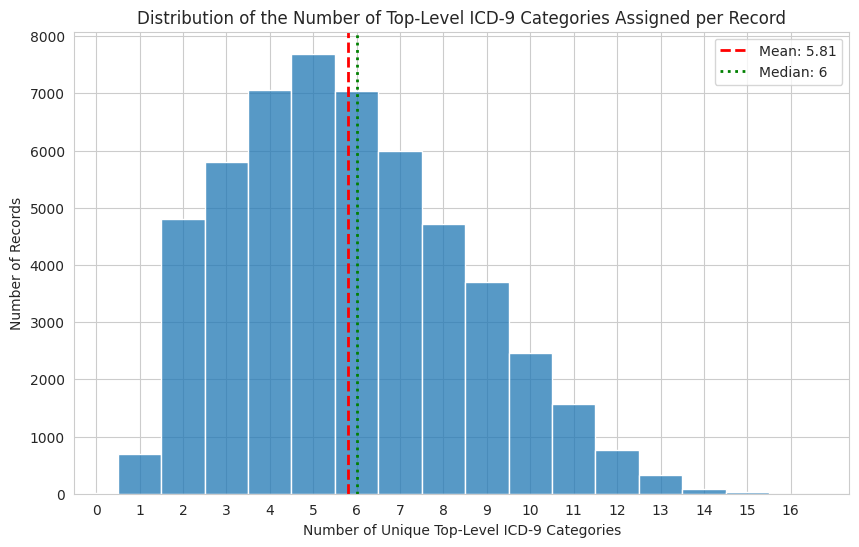

In [138]:
# Visualize the distribution of the number of categories per record
plt.figure(figsize=(10, 6))
max_tick = min(max_cats + 1, 25)
sns.histplot(df_full['NumCategories'], discrete=True, kde=False)

plt.axvline(avg_cats, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {avg_cats:.2f}')
plt.axvline(median_cats, color='green', linestyle='dotted', linewidth=2, label=f'Median: {median_cats:.0f}')

plt.title('Distribution of the Number of Top-Level ICD-9 Categories Assigned per Record')
plt.xlabel('Number of Unique Top-Level ICD-9 Categories')
plt.ylabel('Number of Records')
plt.xticks(range(min_cats, max_tick))
plt.xlim(left=-0.5)
plt.legend()
plt.show()

### Observations

With the previous analysis, we can see that records have an average of **5.81 (median of 6)** top-level ICD-9 assigned categories. 

# 4. Clinical Discharge Note Length Analysis

Let's analyze the length (number of characters) of the discharge clinical notes in the `TEXT` column of the dataset.

In [139]:
df_full['TEXT'] = df_full['TEXT'].astype(str)

# Calculate text length
df_full['TextLength'] = df_full['TEXT'].apply(len)

# Calculate statistics
min_len = df_full['TextLength'].min()
max_len = df_full['TextLength'].max()
avg_len = df_full['TextLength'].mean()
median_len = df_full['TextLength'].median()

print(f"Statistics for TEXT Length (Number of Characters):")
print("-" * 80) 
print(f"  Minimum: {min_len}")
print(f"  Maximum: {max_len}")
print(f"  Average: {avg_len:.2f}")
print(f"  Median:  {median_len:.0f}")

print("\nText Length Quantiles:")
print("-" * 80) 
print(df_full['TextLength'].describe(percentiles=[.01, .1, .25, .5, .75, .9, .99]))

Statistics for TEXT Length (Number of Characters):
--------------------------------------------------------------------------------
  Minimum: 215
  Maximum: 55738
  Average: 10395.53
  Median:  9480

Text Length Quantiles:
--------------------------------------------------------------------------------
count    52722.000000
mean     10395.527351
std       5236.080240
min        215.000000
1%        2237.210000
10%       4759.100000
25%       6661.000000
50%       9479.500000
75%      13086.750000
90%      17117.900000
99%      27069.740000
max      55738.000000
Name: TextLength, dtype: float64


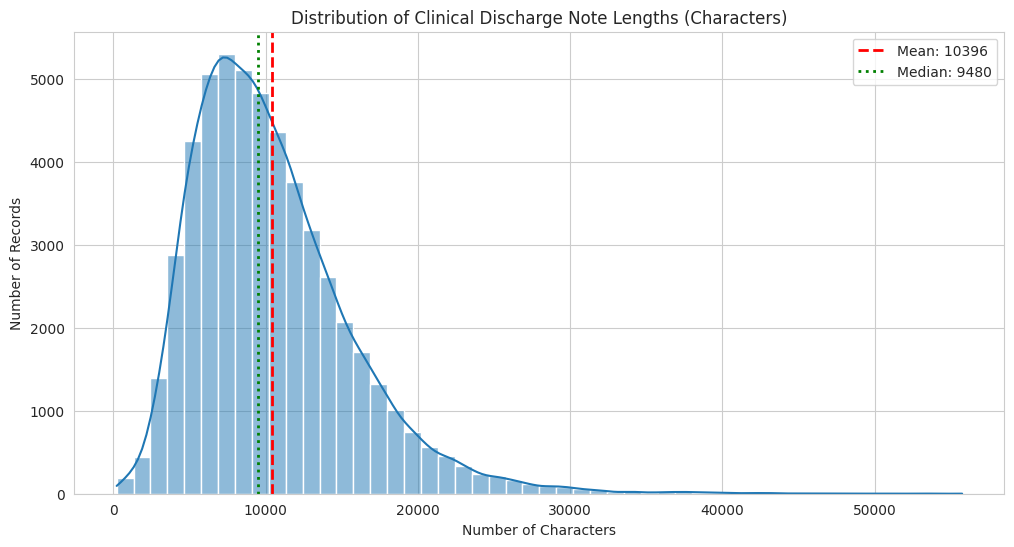

In [140]:
# Visualize the distribution of text lengths
plt.figure(figsize=(12, 6))
sns.histplot(df_full['TextLength'], bins=50, kde=True)

plt.axvline(avg_len, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {avg_len:.0f}')
plt.axvline(median_len, color='green', linestyle='dotted', linewidth=2, label=f'Median: {median_len:.0f}')

plt.title('Distribution of Clinical Discharge Note Lengths (Characters)')
plt.xlabel('Number of Characters')
plt.ylabel('Number of Records')
plt.legend()
plt.show()

# 5. Top-Level ICD-9 Category Distribution Comparison (Train vs. Test Sets)

Ideally, the proportions for each category should be very similar between the two sets.

In [141]:
df_train['CategoryList'] = df_train['TopLevelICD'].apply(get_categories)
df_test['CategoryList'] = df_test['TopLevelICD'].apply(get_categories)

# Count categories in Train set
train_category_ids = Counter()
for cat_list in df_train['CategoryList']:
    train_category_ids.update(cat_list)
train_counts = pd.DataFrame(train_category_ids.items(), columns=['CategoryID', 'TrainCount']).set_index('CategoryID')
train_counts['TrainProportion'] = train_counts['TrainCount'] / n_train # Proportion of TRAIN records having this category

# Count categories in Test set
test_category_ids = Counter()
for cat_list in df_test['CategoryList']:
    test_category_ids.update(cat_list)
test_counts = pd.DataFrame(test_category_ids.items(), columns=['CategoryID', 'TestCount']).set_index('CategoryID')
test_counts['TestProportion'] = test_counts['TestCount'] / n_test # Proportion of TEST records having this category

# Combine counts for comparison, map names, sort numerically
all_unique_category_ids = sorted(
    list(set(train_category_ids.keys()) | set(test_category_ids.keys())),
    key=get_cat_sort_key # Sort IDs numerically
)

comparison_df = pd.DataFrame(index=all_unique_category_ids)
comparison_df = comparison_df.join(train_counts).join(test_counts).fillna(0) # Use join and fillna
comparison_df[['TrainCount', 'TestCount']] = comparison_df[['TrainCount', 'TestCount']].astype(int) # Ensure counts are integers
comparison_df = comparison_df.reset_index().rename(columns={'index': 'CategoryID'})
comparison_df['CategoryName'] = comparison_df['CategoryID'].map(category_mapping).fillna('Unknown Category')

print("\nCategory Counts and Proportions in Train vs. Test Sets (Sorted Numerically):")
print("-" * 120) 
display_cols = ['CategoryName', 'TrainCount', 'TrainProportion', 'TestCount', 'TestProportion']
print(comparison_df[display_cols].to_string(index=False))


Category Counts and Proportions in Train vs. Test Sets (Sorted Numerically):
------------------------------------------------------------------------------------------------------------------------
                                                  CategoryName  TrainCount  TrainProportion  TestCount  TestProportion
                     1: Infectious & Parasitic (ICD-9 001-139)       10664         0.269695       3548        0.269175
                                  2: Neoplasms (ICD-9 140-239)        6458         0.163324       2121        0.160913
       3: Endocrine, Nutritional and Metabolic (ICD-9 240-279)       25947         0.656205       8653        0.656475
               4: Blood & Blood-forming Organs (ICD-9 280-289)       14286         0.361296       4720        0.358091
                           5: Mental Disorders (ICD-9 290-319)       11851         0.299714       3880        0.294363
                             6: Nervous System (ICD-9 320-359)       10031         0.25

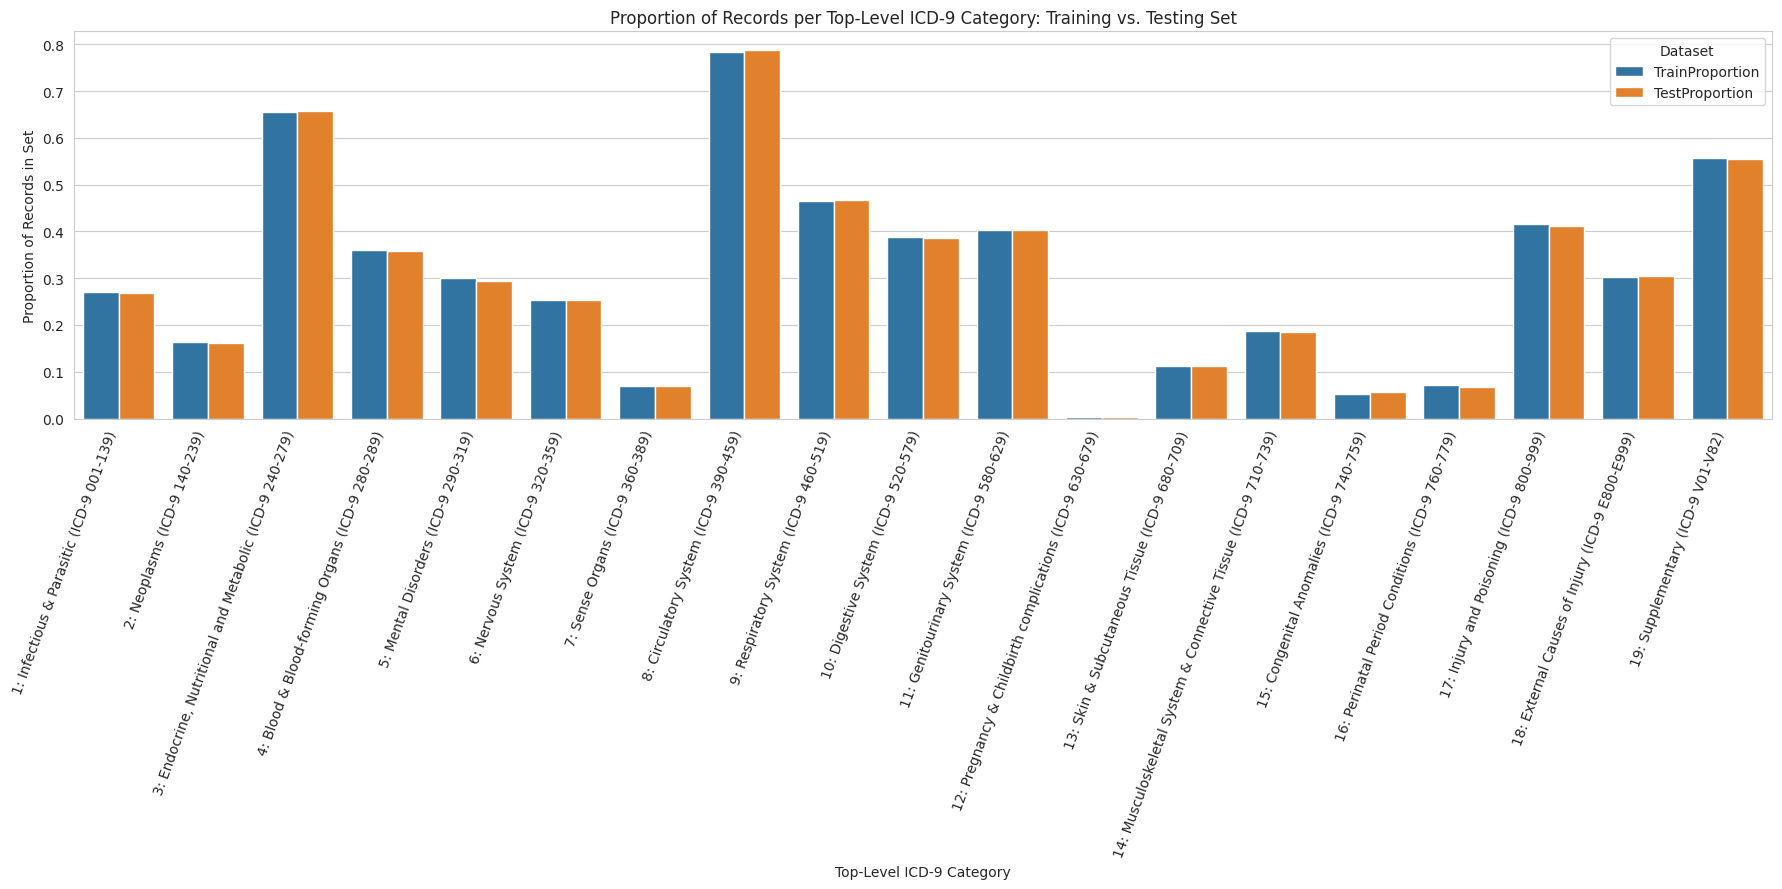

In [143]:
# Visualize the comparison
comp_melt = comparison_df[['CategoryName', 'TrainProportion', 'TestProportion']].melt(
    id_vars='CategoryName', var_name='Dataset', value_name='Proportion'
)

plt.figure(figsize=(18, 9))
sns.barplot(x='CategoryName', y='Proportion', hue='Dataset', data=comp_melt, order=comparison_df['CategoryName'])
plt.title('Proportion of Records per Top-Level ICD-9 Category: Training vs. Testing Set')
plt.xlabel('Top-Level ICD-9 Category')
plt.ylabel('Proportion of Records in Set')
plt.xticks(rotation=70, ha='right')
plt.legend(title='Dataset')
plt.tight_layout()
plt.show()

# 6. Summary
The exploratory analysis provided a comprehensive understanding of the dataset, which can be summarized as follows:
1. The dataset was successfully split into training (approximately 75%) and testing (25%) sets, aligning with the experimental setup described in **Table 2** of the KeyClass paper.
2. Records are annotated with an average of **5 to 6** top-level ICD-9 categories, confirming the multi-label nature of the task. Notably, only 8 records (0.02%) lack any associated category labels.
3. Class imbalance is evident in the category distribution. For instance, the categories **Circulatory System (ICD-9 390-459)** and **Endocrine, Nutritional and Metabolic (ICD-9 240-279)** are heavily represented, whereas **Pregnancy & Childbirth Complications (ICD-9 630-679)** appears in just 0.56% of the samples.
4. Discharge note lengths vary widely, with an average of **10,395** characters, ranging from a minimum of **215** to a maximum of **55,738** characters.
5. The distribution of categories is very consistent between the training and testing sets.